# Intro/Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import joblib
import pathlib as path
import copy

# Data Read-in

In [2]:
rawData = pd.read_csv('STEMVisualsSynthData.csv', header=0)
#remove unneeded column
rawData.drop('Index_within_Experiment', axis = 1, inplace = True)
#X is inputs--the three Concentrations, F_in, I0 (light intensity), and c_N_in (6)
X = rawData[['Time', 'C_X', 'C_N', 'C_L', 'F_in', 'C_N_in', 'I0']]
Y = X.copy(deep=True)
#drop unnecessary rows in Y
Y.drop('F_in', axis = 1, inplace = True)
Y.drop('C_N_in', axis = 1, inplace = True)
Y.drop('I0', axis = 1, inplace = True)
Y.drop('Time', axis = 1, inplace = True)
#Y vals should be X concentrations one timestep ahead, so remove the first index
Y.drop(index=0, inplace=True)
#To keep the two consistent, remove the last index of X
X.drop(index=19999, inplace=True)
#separate the times out into their own little thing for later use

C:\Users\kenda\AppData\Local\Temp\ipykernel_31968\3039068683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index=19999, inplace=True)


# Train/Val/Test Split

In [3]:
#create training/validate/testing splits
train_ratio = 0.60
validation_ratio = 0.10
test_ratio = 0.20

# train is now 75% of the entire data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

#Separate Time out--we don't want this as a feature the model learns (since it's already incorporated in by how X and Y are structured!)
#however, having the time values will be useful for plotting later
XTrainTime = X_train.pop('Time')
XValTime = X_val.pop('Time')
XTestTime = X_test.pop('Time')

# Data Preprocessing

In [4]:
stScalerX = preprocessing.StandardScaler().fit(X_train[['C_L', 'F_in', 'I0', 'C_N_in']])
stScalerY = preprocessing.StandardScaler().fit(Y_train[['C_L']])

pTransformX = preprocessing.PowerTransformer().fit(X_train[['C_X', 'C_N']])
pTransformY = preprocessing.PowerTransformer().fit(Y_train[['C_X', 'C_N']])

#apply all the transformations to the data
X_train[['C_L', 'F_in', 'I0', 'C_N_in']] = stScalerX.transform(X_train[['C_L', 'F_in', 'I0', 'C_N_in']])
X_train[['C_X', 'C_N']] = pTransformX.transform(X_train[['C_X', 'C_N']])
Y_train[['C_L']] = stScalerY.transform(Y_train[['C_L']])
Y_train[['C_X', 'C_N']] = pTransformY.transform(Y_train[['C_X', 'C_N']])
X_val[['C_L', 'F_in', 'I0', 'C_N_in']] = stScalerX.transform(X_val[['C_L', 'F_in', 'I0', 'C_N_in']])
X_val[['C_X', 'C_N']] = pTransformX.transform(X_val[['C_X', 'C_N']])
Y_val[['C_L']] = stScalerY.transform(Y_val[['C_L']])
Y_val[['C_X', 'C_N']] = pTransformY.transform(Y_val[['C_X', 'C_N']])
X_test[['C_L', 'F_in', 'I0', 'C_N_in']] = stScalerX.transform(X_test[['C_L', 'F_in', 'I0', 'C_N_in']])
X_test[['C_X', 'C_N']] = pTransformX.transform(X_test[['C_X', 'C_N']])
Y_test[['C_L']] = stScalerY.transform(Y_test[['C_L']])
Y_test[['C_X', 'C_N']] = pTransformY.transform(Y_test[['C_X', 'C_N']])
#save the scalers for later use
joblib.dump(stScalerX, 'models/stScalerX.pkl')
joblib.dump(stScalerY, 'models/stScalerY.pkl')
joblib.dump(pTransformX, 'models/pTransformX.pkl')
joblib.dump(pTransformY, 'models/pTransformY.pkl')


['models/pTransformY.pkl']

# Create Tensors

In [5]:
#convert to tensors
X_train = torch.tensor(X_train.values, dtype=torch.float)
y_train = torch.tensor(Y_train.values, dtype=torch.float)
X_val = torch.tensor(X_val.values, dtype=torch.float)
y_val = torch.tensor(Y_val.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_test = torch.tensor(Y_test.values, dtype=torch.float)

# Model

In [6]:
model = nn.Sequential(
    nn.Linear(6, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 25),
    nn.LeakyReLU(),
    nn.Linear(25, 3)
)
#loss/optimizer
loss_fn = nn.MSELoss() #Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Model

In [7]:
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 500  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
trainLoss = []
valLoss = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    trainLoss.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    
    #validation loss
    y_pred = model(X_val)
    mse = loss_fn(y_pred, y_val)
    mse = float(mse)
    valLoss.append(mse)
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MSE: 0.05
RMSE: 0.22


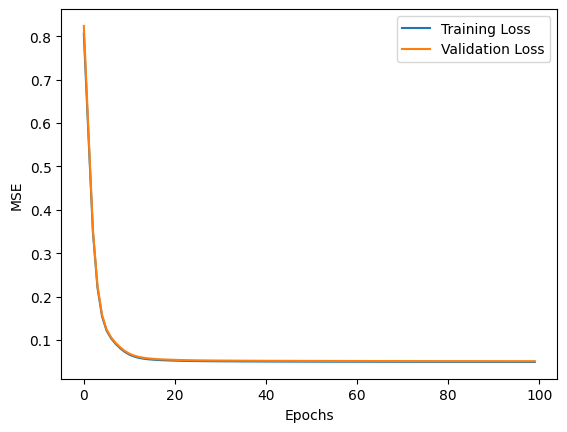

In [8]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(trainLoss, label="Training Loss")
plt.plot(valLoss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

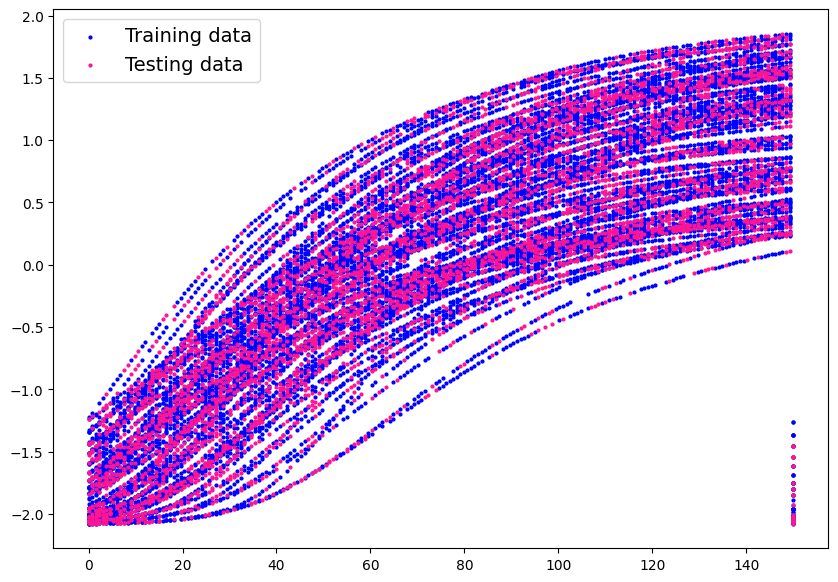

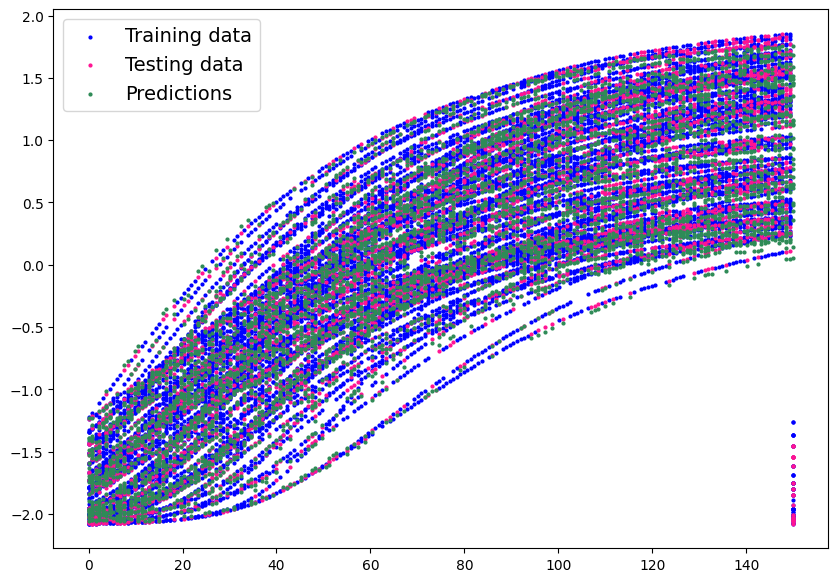

In [9]:
#quick visual just to see our data
def plot_predictions(train_data=XTrainTime, 
                     train_labels=y_train[:, 0], 
                     test_data=XTestTime, 
                     test_labels=y_test[:, 0], 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7)) #create the base of our figure, figsize feeds in width/height in inches

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data") #c for color, s for size. 
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="deeppink", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="seagreen", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions();
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  y_preds = model(X_test)
y_preds 
plot_predictions(predictions= torch.Tensor.cpu(y_preds[:, 0])) # gotta make sure that the model is on the cpu for this to work--this'll do nothing if already on cpu


In [10]:
torch.save(model, 'models/model.pt')